# SMS Spam Classifier

## Objective: 

To develop a robust SMS spam classifier utilizing machine learning techniques that effectively distinguish between legitimate and spam text messages, with the aim of enhancing user experience and privacy by reducing unwanted SMS communication.

### Lets' Start

In [97]:
# importing libraries:

# basic:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# for preprocessing:

import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

# evaluation metrics:

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer

In [2]:
# loading the dataset:

df = pd.read_csv("C:/Users/dk957/Downloads/sms spam collection dataset.csv", encoding='ISO-8859-1')

In [3]:
# dataset first view:

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# checking dataset size:

df.shape

(5572, 5)

In [5]:
# checking the null values of the dataset:

df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Observation: Features Unnamed: 2, Unnamed: 3 and Unnamed: 4 have almost all null values.

In [6]:
# checking duplicate values:

df.duplicated().sum()

403

What do you know about the dataset:

1. The dataset has 5572 records and 5 features.
2. There are 0 duplicate values.
3. Features Unnamed: 2, Unnamed: 3 and Unnamed: 4 have almost all null values.
4. There are total 403 duplicate values.

## Data Wrangling

In [7]:
# removing features Unnamed: 2, Unnamed: 3 and Unnamed: 4:

df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [8]:
# removing duplicate values:

df.drop_duplicates(keep='first', inplace=True)

In [9]:
# renaming columns for convenience:

df.rename(columns={'v1':'label', 'v2':'sms'}, inplace=True)

In [10]:
# replacing the term 'ham' with 'not spam' to avoid confusion:

df['label'] = df['label'].apply(lambda x: 'not spam' if x=='ham' else x)

In [11]:
# creating a new column showing total of number of characters in each sms:

df['characters'] = df['sms'].apply(len)

In [12]:
# creating a new column showing total of number of words in each sms:

df['words'] = df['sms'].apply(lambda x: len(word_tokenize(x)))

In [13]:
# creating a new column showing total of number of sentences in each sms:

df['sentences'] = df['sms'].apply(lambda x: len(sent_tokenize(x)))

In [14]:
# Checking the dataset:

df.head()

,label,sms,characters,words,sentences
0,not spam,"Go until jurong point, crazy.. Available only ...",111,24,2
1,not spam,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,not spam,U dun say so early hor... U c already then say...,49,13,1
4,not spam,"Nah I don't think he goes to usf, he lives aro...",61,15,1


## Exploratory Data Analysis

C:\Users\dk957\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Label Counts')

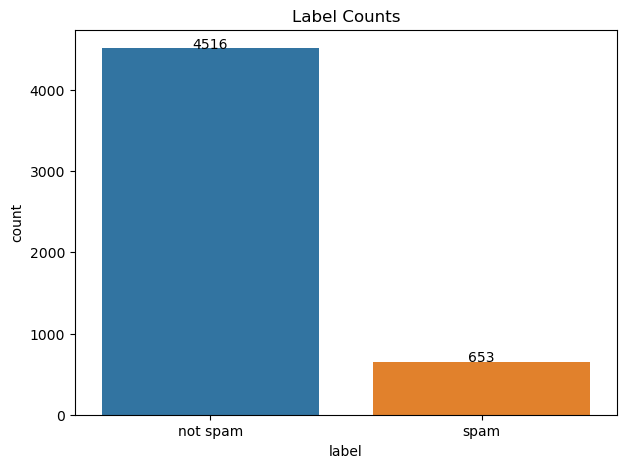

In [15]:
# labelcounts:

plt.figure(figsize=(7,5))

ax = sns.countplot(df['label'])

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')

plt.title('Label Counts')

Text(0.5, 1.0, 'Percentage of Class Distribution')

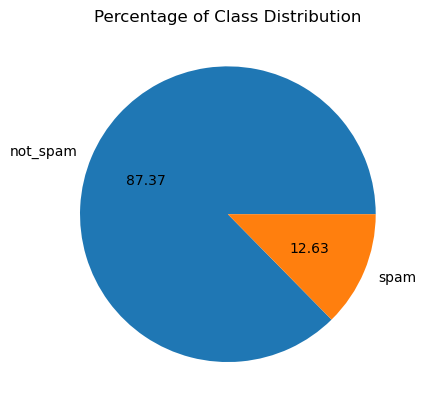

In [16]:
# distribution of class lables in percentage:

plt.pie(list(df['label'].value_counts()), labels = ['not_spam', 'spam'], autopct = '%.2f')
plt.title('Percentage of Class Distribution')

Text(0.5, 1.0, 'Characters Distribtuion')

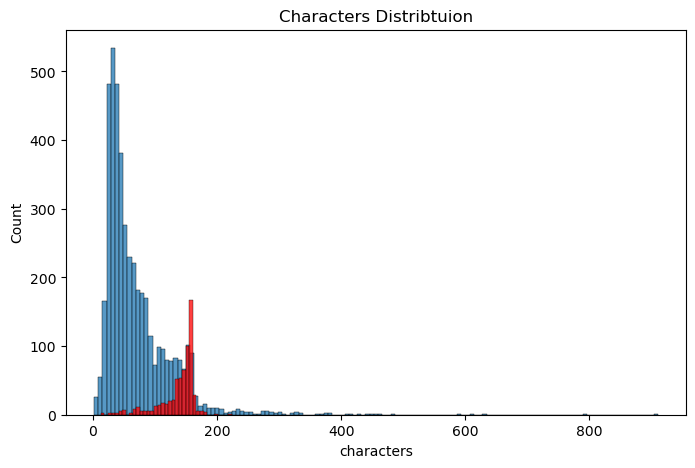

In [18]:
# Distribution of number of characters:

plt.figure(figsize=(8,5))

# for not spam
sns.histplot(x=df[df['label']=='not spam']['characters'])

# for spam
sns.histplot(x=df[df['label']=='spam']['characters'], color = 'red')

plt.title('Characters Distribtuion')

Observation:

Most of the not spam SMS have less characters around 50 compared to spam sms with around 170 characters.

Text(0.5, 1.0, 'Words Distribtuion')

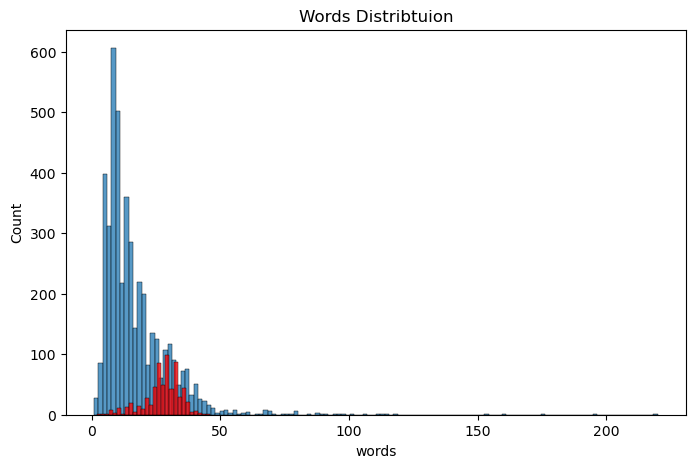

In [19]:
# Distribution of number of Words:

plt.figure(figsize=(8,5))

# for not spam
sns.histplot(x=df[df['label']=='not spam']['words'])

# for spam
sns.histplot(x=df[df['label']=='spam']['words'], color = 'red')

plt.title('Words Distribtuion')

Observation:

Most of the not spam SMS have less words around 10-15 compared to spam sms with around 30-40 characters.

Text(0.5, 1.0, 'Not Spam Sentences Distribtuion')

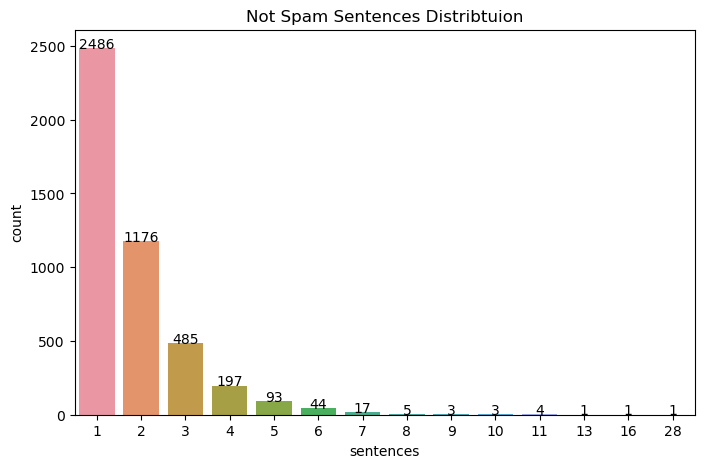

In [20]:
# Distribution of number of Sentences:

plt.figure(figsize=(8,5))

# for not spam
ay = sns.countplot(x=df[df['label']=='not spam']['sentences'])

# Add labels to the bars
for p in ay.patches:
    ay.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')

plt.title('Not Spam Sentences Distribtuion')

Observation:

Not Spam SMS with 1 sentence have the highest count of 2486 among all showing that not SMS are more likely to have 1 sentence.

Text(0.5, 1.0, 'Spam Sentences Distribtuion')

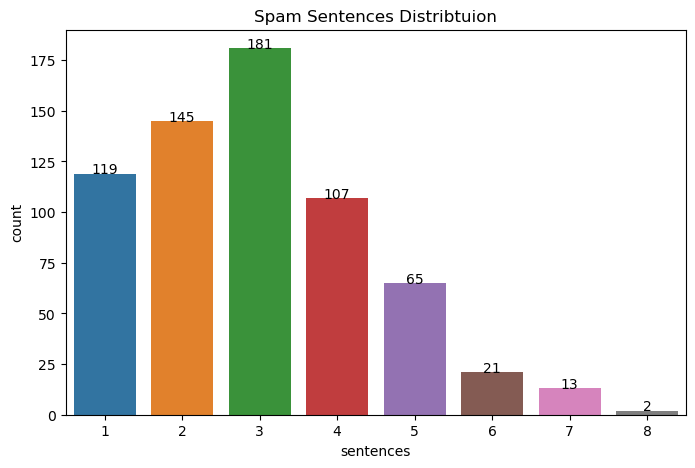

In [21]:
# for spam

# Distribution of number of Sentences:

plt.figure(figsize=(8,5))

# for not spam
az =sns.countplot(x=df[df['label']=='spam']['sentences'])

# Add labels to the bars
for p in az.patches:
    az.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')

plt.title('Spam Sentences Distribtuion')

Observation:

Spam SMS with 3 sentence have the highest count of 181 among all showing that spam SMS are more likely to have more sentences.

Text(0.5, 1.0, 'Correlation Heatmap')

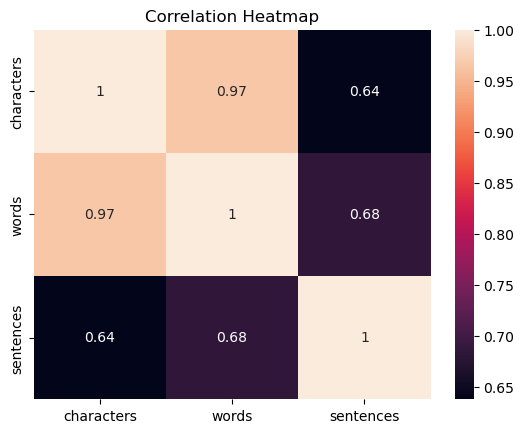

In [22]:
# correlation heatmap:

corr = df.corr()

sns.heatmap(corr, annot=True, cbar=True)

plt.title('Correlation Heatmap')

Observation:
    
All numerical columns have very high correlation with each other. This Mulicolinearity can reduce model performance. Therefore, it will be a good practice to consider only 1 out of these 3 features as an input for the model training.

## Text Preprocessing

In [28]:
# reviewing data:
df.head()

,label,sms,characters,words,sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [27]:
# applying label encoding on 'target feature:

le = LabelEncoder()

df['label'] = le.fit_transform(df['label'])

In [51]:
# creating a list of stopwords manually as nltk is showing error:

stopwords = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",
    "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the",
    "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
    "with", "about", "against", "between", "into", "through", "during", "before", "after",
    "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
    "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "nor", "only", "own",
    "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
]

In [71]:
# creating a function to apply text preprocessing:

def text_processing(sent):
    
    # conversion into lower case
    sent = sent.lower()
    
    # punctuations removal
    sent = re.sub("[^a-zA-Z0-9]"," ",sent)
    
    # tokanization
    sent = nltk.word_tokenize(sent)
    
    # assigning empty list:
    empty = []
    
    # stop words removal:
    for i in sent:
        if i not in stopwords:
            empty.append(i)
            
    # stemming:
    ps = PorterStemmer()
    
    empty = [ps.stem(word) for word in empty]
             
    return " ".join(empty)

In [74]:
# applying the function on textual column:

df['processed_text'] = df['sms'].apply(text_processing)

In [78]:
# applying vectorization using TF-IDF vectorizor:

#limiting the max features upto 3000 to avoid system crash
tfidf = TfidfVectorizer(max_features = 3000)

vectors = tfidf.fit_transform(df['processed_text']).toarray()

In [80]:
# reviewing vector:

vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model Training and Evaluation

In [86]:
# performing train_test_split:

X_train, X_test, y_train, y_test = train_test_split(vectors, df['label'].values, test_size = 0.2, random_state=1)

In [89]:
# creating objects of models to be used for training:

log = LogisticRegression()
dt = DecisionTreeClassifier()
svc = SVC()
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xg = XGBClassifier()

In [92]:
for model in [log,dt,svc,gnb,mnb,bnb,rf,adb,gb,xg]:
    
    model.fit(X_train, y_train)
    
    print(f'For {model}')
    
    print(f'accuracy: {accuracy_score(y_test, model.predict(X_test))}')
    print(f'precision: {precision_score(y_test, model.predict(X_test))}')
    print(f'recall: {recall_score(y_test, model.predict(X_test))}')
    print("------------------------------------------")

For LogisticRegression()
accuracy: 0.9458413926499033
precision: 0.9647058823529412
recall: 0.6074074074074074
------------------------------------------
For DecisionTreeClassifier()
accuracy: 0.9487427466150871
precision: 0.8203125
recall: 0.7777777777777778
------------------------------------------
For SVC()
accuracy: 0.9709864603481625
precision: 0.981651376146789
recall: 0.7925925925925926
------------------------------------------
For GaussianNB()
accuracy: 0.8684719535783365
precision: 0.4978723404255319
recall: 0.8666666666666667
------------------------------------------
For MultinomialNB()
accuracy: 0.9671179883945842
precision: 1.0
recall: 0.7481481481481481
------------------------------------------
For BernoulliNB()
accuracy: 0.9748549323017408
precision: 0.990990990990991
recall: 0.8148148148148148
------------------------------------------
For RandomForestClassifier()
accuracy: 0.9729206963249516
precision: 1.0
recall: 0.7925925925925926
---------------------------------

Focusing more on precision metric as it is important to reduce False Positive so that Non-Spam messages are not sent to spam.

Before Hyperparameter Tuning RandomForest (accuracy = 97, precision = 100) and MultinomialNB (accuracy = 96, precision = 100) are performing best among all above models.

### Hyperparameter Tuning:

### Support Vector Classifier

In [98]:
# possible values:
svc_params = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
}

# gridsearchcv

# Create the SVC model
svc = SVC()

# Create a GridSearchCV instance for accuracy
accuracy_scorer = make_scorer(accuracy_score)
svc_accuracy = GridSearchCV(estimator=svc, param_grid=svc_params, scoring=accuracy_scorer, cv=5)

# Create a GridSearchCV instance for precision
precision_scorer = make_scorer(precision_score)
svc_precision = GridSearchCV(estimator=svc, param_grid=svc_params, scoring=precision_scorer, cv=5)

# Fit both GridSearchCV instances to your data
svc_accuracy.fit(X_train, y_train)
svc_precision.fit(X_train, y_train)

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

accuracy: 0.9758220502901354


NameError: name 'svc_prevision' is not defined

In [107]:
# Print
print(f'accuracy: {accuracy_score(y_test, svc_accuracy.predict(X_test))}')
print(f'precision: {precision_score(y_test, svc_precision.predict(X_test))}')
print(f'recall: {recall_score(y_test, svc_precision.predict(X_test))}')

accuracy: 0.9758220502901354
precision: 0.984375
recall: 0.4666666666666667


Observation: Not much improvement in Support Vector Classifier after Hyperparameter Tuning

### Multinomial Naive Bias Classifier:

In [100]:
# possible values:
multinomial_nb_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# gridsearchcv

# Create the SVC model
mnb = MultinomialNB()

# Create a GridSearchCV instance for accuracy
accuracy_scorer = make_scorer(accuracy_score)
mnb_accuracy = GridSearchCV(estimator=mnb, param_grid=multinomial_nb_params, scoring=accuracy_scorer, cv=5)

# Create a GridSearchCV instance for precision
precision_scorer = make_scorer(precision_score)
mnb_precision = GridSearchCV(estimator=mnb, param_grid=multinomial_nb_params, scoring=precision_scorer, cv=5)

# Fit both GridSearchCV instances to your data
mnb_accuracy.fit(X_train, y_train)
mnb_precision.fit(X_train, y_train)

# Print
print(f'accuracy: {accuracy_score(y_test, mnb_accuracy.predict(X_test))}')
print(f'accuracy: {precision_score(y_test, mnb_precision.predict(X_test))}')

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.9825918762088974
accuracy: 1.0


C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dk957\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
# Checking performance of both trained GridSearchCVs with accuracy and precision metrics: 

print("With Accuracy trained--------------------")
print(f'accuracy: {accuracy_score(y_test, mnb_accuracy.predict(X_test))}')
print(f'Precision: {precision_score(y_test, mnb_accuracy.predict(X_test))}')
print(f'Recall: {recall_score(y_test, mnb_accuracy.predict(X_test))}')

print("------------------------------")
print("------------------------------")

print("With Precision trained--------------------")
print(f'accuracy: {accuracy_score(y_test, mnb_precision.predict(X_test))}')
print(f'Precision: {precision_score(y_test, mnb_precision.predict(X_test))}')
print(f'Recall: {recall_score(y_test, mnb_precision.predict(X_test))}')

With Accuracy trained--------------------
accuracy: 0.9825918762088974
Precision: 0.968
Recall: 0.8962962962962963
------------------------------
------------------------------
With Precision trained--------------------
accuracy: 0.9671179883945842
Precision: 1.0
Recall: 0.7481481481481481


Observation: 

After hyperparameter tuning:
1. The accuracy of accuracy metrics trained model is improved by 2% however, precision decreased by 2% which is our main focus.
2. There is no improvement in precision metrics trained model.

Proceeding with Precision_trained gridsearchcv model as best performing as it is giving 100% of precision score.

### Random Forest Classifier

In [102]:
# possible values:
random_forest_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# gridsearchcv

# Create the SVC model
rf = RandomForestClassifier()

# Create a GridSearchCV instance for accuracy
accuracy_scorer = make_scorer(accuracy_score)
rf_accuracy = GridSearchCV(estimator=rf, param_grid=random_forest_params, scoring=accuracy_scorer, cv=5)

# Create a GridSearchCV instance for precision
precision_scorer = make_scorer(precision_score)
rf_precision = GridSearchCV(estimator=rf, param_grid=random_forest_params, scoring=precision_scorer, cv=5)

# Fit both GridSearchCV instances to your data
rf_accuracy.fit(X_train, y_train)
rf_accuracy.fit(X_train, y_train)

# Print
print(f'accuracy: {accuracy_score(y_test, rf_accuracy.predict(X_test))}')
print(f'accuracy: {precision_score(y_test, rf_precision.predict(X_test))}')

C:\Users\dk957\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dk957\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dk957\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\dk957\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\dk957\anaconda3\lib\site-packa

accuracy: 0.971953578336557


NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Due to computational issue, the training time of RandomForest with hyperparameter turning is extremely large. Therefore, processing with Multinomial Naive Bias Classifier which is giving optimal results.

## Importing required files for Deployment

In [110]:
# importing pickle 
import pickle

# saving required objects in pickle format
pickle.dump(mnb_precision, open('mnb.pkl', 'wb'))
pickle.dump(text_processing, open('text_function.pkl','wb'))
pickle.dump(tfidf, open('tfidf.pkl','wb'))

### Proceeding for SMS Spam Classifier Model Deployment using Pycharm.